<a href="https://colab.research.google.com/github/smhall97/hallucinating_GANs/blob/main/CNN_finetuning_mel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Imports

import os
import glob
#import imageio
#import random, shutil
import torch
#import gc
#import csv
#import multiprocessing
#import requests
import time
import copy
#import librosa
#import librosa.display

#import pandas as pd
import numpy as np
#import cv2 as cv
import matplotlib.pyplot as plt
#import IPython.display as display
import pickle
from tqdm.notebook import tqdm



import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [2]:
# @title Set Device

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device

In [3]:
# @title Mount Google Drive

from google.colab import drive
drive.mount('/content/drive') #it will ask you for a verification code


Mounted at /content/drive


In [4]:
# @title some functions

def scale_minmax(X):

    X_scaled = (X - X.min()) / (X.max() - X.min())

    return X_scaled


def pickle_loader_mel(file):
  with open(file, 'rb') as f:
      data = pickle.load(f)
      data = np.transpose(data, axes=[1, 2, 0])
      data = scale_minmax(data)

      zeros = np.zeros(data.shape)

      data = np.concatenate((data, data, data), axis=2)

  return(data)


def pickle_loader_stft(file):
  with open(file, 'rb') as f:
      data = pickle.load(f)
      data = np.squeeze(data, axis=0)

      #real and imaginary parts are scaled independently
      data[:,:,0] = scale_minmax(data[:,:,0])
      data[:,:,1] = scale_minmax(data[:,:,1])

      zeros = np.zeros((data.shape[0],data.shape[1],1))
      data = np.concatenate((data, zeros), axis=2)

  return(data)


def make_sets(classes, items_per_class, ratios):
  """
  parameters:
  classes: number of classes in dataset
  items_per_class: elements per class (assumes that the dataset is balanced across classes)
  ratios: list or array with ratios for each subset [ratio_trainining, ratio_validation, ratio_test]
  """

  train_size = ratios[0] * items_per_class
  val_size = ratios[1] * items_per_class
  test_size = ratios[2] * items_per_class

  test_ix, val_ix, train_ix = np.array([]),np.array([]),np.array([])

  for i in range(classes): 
    class_ix = items_per_class * i
    
    train_ix = np.append(train_ix, np.arange(train_size) + class_ix)
    val_ix = np.append(val_ix, np.arange(train_size, train_size + val_size) + class_ix)
    test_ix = np.append(test_ix, np.arange(train_size + val_size, train_size + val_size + test_size) + class_ix)

  return train_ix.astype(int), val_ix.astype(int), test_ix.astype(int)

In [5]:
# @title Paths and script parameters

dummy_mode = False

path = '/content/drive/MyDrive/HallucinatingGANs/Code/data/'

transform = 'mel'

n_fft = 1024
n_mels = 128
hop_length = 256 # smaller hop size leads to better reconstruction but takes longer to compute
power = 2.0 # squared power spectrogram
samplerate =  22050

def get_cfg_transform(t):
  if t == 'stft':
    params = '{}_{}'.format(str(n_fft), str(hop_length))
    pickle_loader = pickle_loader_stft
  
  elif t == 'mel':
    params = '{}_{}_{}'.format(str(n_fft), str(hop_length), n_mels)
    pickle_loader = pickle_loader_mel
  return params, pickle_loader

#if dummy_mode:


In [6]:
params, pickle_loader = get_cfg_transform(transform)

data_dir = os.path.join(os.path.abspath(path), 'spectrograms', transform, params)
print(data_dir)

data_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.CenterCrop((128, 2080)),
                                      transforms.Resize((128, 1290)), #here i just downsample bc colab cannot handle the big version (out-of-memory crash)
                                      transforms.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])
                                      ])

dataset = torchvision.datasets.DatasetFolder(root=data_dir,
                                             transform = data_transforms, 
                                             loader=pickle_loader, 
                                             extensions='.pkl', 
                                             )

genres = list(os.listdir(data_dir))
n_classes = len(genres) 

train_ix, val_ix, test_ix = make_sets(n_classes, 100, [.8, .1, .1])

subsets = {
          'train': torch.utils.data.Subset(dataset, train_ix),
          'val': torch.utils.data.Subset(dataset, val_ix)
          }

dataloaders = {x: torch.utils.data.DataLoader(subsets[x], batch_size=25,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
print(dataset_sizes)

/content/drive/MyDrive/HallucinatingGANs/Code/data/spectrograms/mel/1024_256_128
{'train': 800, 'val': 100}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
#dataset[0][0].shape
print(dataset[0][0].shape, dataset[0][0].dtype)
print(dataset)
print(torch.min(dataset[0][0]))
print(torch.max(dataset[0][0]))
print(torch.mean(dataset[0][0]))
print(torch.std(dataset[0][0]))
#print(dataset[0][0][1])
#print(dataset[0][0][2])






torch.Size([3, 128, 1290]) torch.float32
Dataset DatasetFolder
    Number of datapoints: 1000
    Root location: /content/drive/MyDrive/HallucinatingGANs/Code/data/spectrograms/mel/1024_256_128
    StandardTransform
Transform: Compose(
               ToTensor()
               CenterCrop(size=(128, 2080))
               Resize(size=(128, 1290), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
tensor(-1.)
tensor(0.9298)
tensor(-0.9966)
tensor(0.0189)


In [8]:
# @title Set device (GPU or CPU)
# NMA code
# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

device = set_device()

GPU is enabled in this notebook.


In [9]:
# @title Load pretrained VGG
"""
code extracted from:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
https://pytorch.org/vision/stable/models.html

"""

vgg16 = models.vgg16(pretrained=True)

# Freeze the network except the last layer / unfreeze layers to allow finetuning
for param in vgg16.parameters():
    param.requires_grad = True # If True it will train

# Parameters of newly constructed modules have requires_grad=True by default
# Add on classifier

vgg16.classifier[6] = nn.Sequential(
                      nn.Linear(vgg16.classifier[3].in_features, 256),
                      nn.ReLU(), 
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [10]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# @title Train model function from PyTorch

# Original code from this tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc_list, val_acc_list = [], []
    # train_loss, validation_loss = [], []
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            num_examples = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                num_examples += inputs.size(0)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            # Different to tutorial, hardcoded dataset size
            # print(dataset_sizes) from above 
            
            #if phase == 'train':
            #    num_examples = len(train_loader) * len(next(iter(train_loader))[0]) 
            #else:
            #    num_examples = len(val_loader) * len(next(iter(val_loader))[0])
            print('number of examples in loader = ', num_examples)
            print(f'RUNNING LOSS: {running_loss}, RUNNING CORRECTS: {running_corrects}')

            epoch_loss = running_loss / num_examples
            print()
            epoch_acc = running_corrects.double() / num_examples
            if phase == 'train':
              train_acc_list.append(epoch_acc)
            else:
              val_acc_list.append(epoch_acc)
          
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # model = model.to('cuda')
    return model, train_acc_list, val_acc_list

In [12]:
# model trains - change num_epochs to increase training time
vgg16 = vgg16.float()
model_ft, train_acc_list, val_acc_list = train_model(vgg16.to(device), criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=20)



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


number of examples in loader =  800
RUNNING LOSS: 1831.12553358078, RUNNING CORRECTS: 92

train Loss: 2.2889 Acc: 0.1150
number of examples in loader =  100
RUNNING LOSS: 223.19725155830383, RUNNING CORRECTS: 23

val Loss: 2.2320 Acc: 0.2300

Epoch 1/19
----------
number of examples in loader =  800
RUNNING LOSS: 1689.725586771965, RUNNING CORRECTS: 218

train Loss: 2.1122 Acc: 0.2725
number of examples in loader =  100
RUNNING LOSS: 181.63073062896729, RUNNING CORRECTS: 35

val Loss: 1.8163 Acc: 0.3500

Epoch 2/19
----------
number of examples in loader =  800
RUNNING LOSS: 1466.3997024297714, RUNNING CORRECTS: 255

train Loss: 1.8330 Acc: 0.3188
number of examples in loader =  100
RUNNING LOSS: 180.46444654464722, RUNNING CORRECTS: 40

val Loss: 1.8046 Acc: 0.4000

Epoch 3/19
----------
number of examples in loader =  800
RUNNING LOSS: 1279.5610398054123, RUNNING CORRECTS: 341

train Loss: 1.5995 Acc: 0.4263
number of examples in loader =  100
RUNNING LOSS: 159.75862741470337, RUNNIN

In [13]:
import psutil
psutil.virtual_memory().total / (1024.0 ** 3)

12.686656951904297

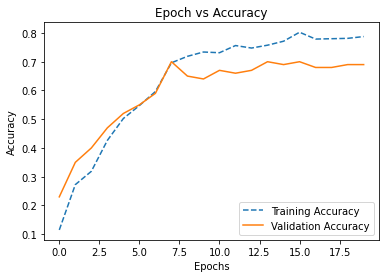

In [14]:
# @title Plot accuracies
def plot_loss_accuracy(train_acc_list, val_acc_list):
  epochs = len(train_acc_list)

  plt.plot(list(range(epochs)), train_acc_list, label='Training Accuracy', linestyle="--")
  plt.plot(list(range(epochs)), val_acc_list, label='Validation Accuracy')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Epoch vs Accuracy')
  plt.legend()
  plt.show()


plot_loss_accuracy(train_acc_list, val_acc_list)


In [15]:
# @title Save model

outfile_name = path + 'vgg16_{}_{}.pt'.format(transform, params)

# save model path
torch.save(model_ft.state_dict(), outfile_name)